<h2><center>Trabalho de conclusão do curso de Especialização em Ciência de Dados da Facens</center></h2>
<h3><center>Faculdade de Engenharia de Sorocaba</center></h3>

**Alunos:** 
<p>
<p>Dani Shizue Sakamoto - RA: 191219
<p>Mariana de Castro Pires Tavares Albuquerque - RA: 191224
<p>Tan Kim Wah - RA: 141462

<h1><center>Treinamento utilizando MTCNN e Rede Residual RESNET-50</center></h1>
<h2><center>(Adulto, Adolescente e Criança)</center></h2>

#### Importando as bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isdir

import cv2
import mtcnn
from mtcnn.mtcnn import MTCNN

from random import shuffle
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50
from keras import optimizers

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


#### Diretórios das imagens

In [ ]:
dir_train_adult = './datasets/images/train/Adult'
dir_train_teen = './datasets/images/train/Teenager'
dir_train_child = './datasets/images/train/Child'

In [ ]:
dir_test_adult = './datasets/images/test/Adult'
dir_test_teen = './datasets/images/test/Teenager'
dir_test_child = './datasets/images/test/Child'

### MTCNN - Multi-task Cascaded Convolutional Neural Networks
https://pypi.org/project/mtcnn/

Palavras-chave: MTCNN, detecção e alinhamento de faces, rede neural convolucional, reconhecimento de faces.

Faz o reconhecimento da face e alinhamento baseado em processamento mais denso de uma rede neural.

#### Instanciando o detector

In [ ]:
face_detector = MTCNN()

#### Função que detecta a face na imagem

In [ ]:
def detect_face_in_image(path, size = (160, 160)):

    face_detected = None
    #Carregando imagem do arquivo
    img = cv2.imread(path)
    
    #cv2.imshow("Original", img)
    #cv2.waitKey(0)
    
    #Executando detecção de rosto
    faces = face_detector.detect_faces(img)
    if (len(faces) > 0):
     
        #Desenha o retângulo de acordo com suas coordenadas
        #Extraindo a caixa delimitadora da face - Boundig box
        x, y, w, h = faces[0]['box']
        xw, yh = x+w, y+h
        img_cropped = img[y:yh, x:xw]
        
        #Resize
        face_detected = cv2.resize(img_cropped, size)
    return face_detected

In [ ]:
labels = ['Adult','Teen','Child']
train_data = []
test_data = []

#### Função que carrega as imagens de treino

In [ ]:
def load_training_data():
 
    for img in os.listdir(dir_train_adult):
        label = 'Adult'
        path = os.path.join(dir_train_adult, img)

        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
                
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                train_data.append([face_array, label_array])
        except:
            pass
        
    for img in os.listdir(dir_train_teen):
        label = 'Teen'
        path = os.path.join(dir_train_teen, img)

        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
                
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                train_data.append([face_array, label_array])
        except:
            pass
        
           
    for img in os.listdir(dir_train_child):
        label = 'Child'
        path = os.path.join(dir_train_child, img)
    
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                train_data.append([face_array, label_array])
        except:
            pass
       
        
    shuffle(train_data)
    return train_data

In [ ]:
train_data = load_training_data()

#### Função que carrega as imagens de teste

In [ ]:
def load_test_data():
   
    for img in os.listdir(dir_test_adult):
        label = 'Adult'
        path = os.path.join(dir_test_adult, img)
 
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                test_data.append([face_array, label_array])
        except:
            pass
    
    for img in os.listdir(dir_test_teen):
        label = 'Teen'
        path = os.path.join(dir_test_teen, img)
 
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                test_data.append([face_array, label_array])
        except:
            pass
    
    
    for img in os.listdir(dir_test_child):
        label = 'Child'
        path = os.path.join(dir_test_child, img)
    
        try:
            #Chama a função que detecta a face
            face_detected = detect_face_in_image(path)
            if np.sum([face_detected])!=0:
               
                face_detected = cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB)
                face_array = np.array(face_detected) / 255.0
                label_array = np.array(label)
                test_data.append([face_array, label_array])
        except:
            pass
       
        
    shuffle(test_data)
    return test_data

In [ ]:
test_data = load_test_data()

In [ ]:
train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

In [ ]:
test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

In [ ]:
le = LabelEncoder()
labels_train = le.fit_transform(train_labels)
labels_test = le.transform(test_labels)

In [ ]:
labels_train = to_categorical(labels_train, num_classes=3)
labels_test = to_categorical(labels_test, num_classes = 3)

In [ ]:
X_train = train_images
y_train = labels_train

In [ ]:
X_test = test_images
y_test = labels_test

In [ ]:
X_train[0].shape

(160, 160, 3)

In [ ]:
y_train[1]

array([1., 0., 0.], dtype=float32)

#### Definindo Hiperparâmetros
<p style='text-align: justify;'>
Os hiperparâmetros definem como deseja treinar a rede neural (períodos de treinamento), tamanho do lote, taxa de aprendizado, função de otimização, configuração da rede neural (camadas, unidades ocultas em camadas, função de ativação, etc). 
Durante a fase de treinamento de um projeto de aprendizado profundo, você pode querer ajustar esses hiperparâmetros para obter o desempenho ideal do modelo de rede neural.</p>

In [ ]:
#A rede tem um tamanho de entrada de imagem de 160 por 160.
num_classes = 3
batchSize   = 32
max_epochs  = 5
image_size  = (160, 160)
inputShape = (160, 160, 3)
optimizer   = optimizers.Adam(lr=0.0001)

## TRANSFER LEARNING
<p style='text-align: justify;'>
A aprendizagem por transferência tem o benefício de diminuir o tempo de treinamento para um modelo de rede neural e pode resultar em um erro de generalização menor. O objetivo é aproveitar os dados da primeira configuração para extrair informações que podem ser úteis ao aprender ou mesmo ao fazer previsões diretamente na segunda configuração.</p>

https://machinelearningmastery.com/how-to-improve-performance-with-transfer-learning-for-deep-learning-neural-networks/ 

### RESNET-50
ResNet-50 é uma rede neural convolucional com 50 camadas de profundidade. 

#### Criando modelo Transfer Learning

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=inputShape)

/home/ec2-user/anaconda3/envs/python-gpu/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dense(3, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#### Ajusta o gerador de treinamento

In [ ]:
print("Iniciando treinamento... ")

history = model.fit(X_train, y_train, batch_size=batchSize, verbose=1, epochs=max_epochs)

print("Treinamento finalizado \n")

Iniciando treinamento... 
Epoch 1/5
10557/10557 [==============================] - 295s 28ms/step - loss: 0.4786 - accuracy: 0.8367
Epoch 2/5
10557/10557 [==============================] - 270s 26ms/step - loss: 0.1608 - accuracy: 0.9441
Epoch 3/5
10557/10557 [==============================] - 270s 26ms/step - loss: 0.0784 - accuracy: 0.9724
Epoch 4/5
10557/10557 [==============================] - 270s 26ms/step - loss: 0.0552 - accuracy: 0.9794
Epoch 5/5
10557/10557 [==============================] - 270s 26ms/step - loss: 0.0389 - accuracy: 0.9871
Treinamento finalizado 



#### Salvando modelo

In [ ]:
model.save("model_resnet_atc.h5")

#### Histórico de treinamento (Precisão e Perda)

dict_keys(['loss', 'accuracy'])


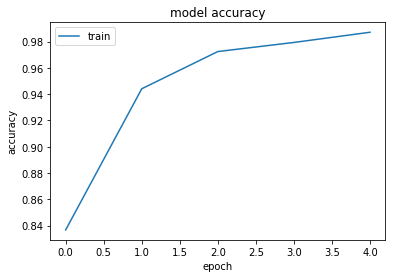

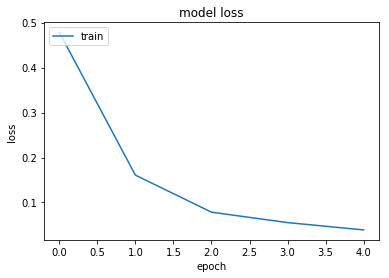

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### Gerador de Predição
Gera previsões para as amostras

In [ ]:
y_pred_train = model.predict(X_train)

y_pred_test = model.predict(X_test)

In [ ]:
y_pred_train = [np.argmax(i) for i in y_pred_train]
y_pred_test = [np.argmax(j) for j in y_pred_test]

In [ ]:
y_pred_train = le.inverse_transform(y_pred_train)
y_pred_test = le.inverse_transform(y_pred_test)

In [ ]:
y_true_train = [np.argmax(i) for i in y_train]
y_true_test = [np.argmax(j) for j in y_test]

In [ ]:
y_true_train = le.inverse_transform(y_true_train)
y_true_test = le.inverse_transform(y_true_test)

In [ ]:
print('Performance do treinamento')
print(classification_report(y_true_train, y_pred_train))

print('Performance do teste')
print(classification_report(y_true_test, y_pred_test))

Performance do treinamento
              precision    recall  f1-score   support

       Adult       0.99      0.97      0.98      5759
       Child       0.99      0.99      0.99      3801
        Teen       0.89      0.97      0.93       997

    accuracy                           0.98     10557
   macro avg       0.96      0.98      0.97     10557
weighted avg       0.98      0.98      0.98     10557

Performance do teste
              precision    recall  f1-score   support

       Adult       0.93      0.95      0.94      2472
       Child       0.95      0.93      0.94      1645
        Teen       0.73      0.68      0.70       437

    accuracy                           0.92      4554
   macro avg       0.87      0.85      0.86      4554
weighted avg       0.91      0.92      0.91      4554



In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)
cm

array([[2348,   44,   80],
       [  88, 1525,   32],
       [ 100,   40,  297]])

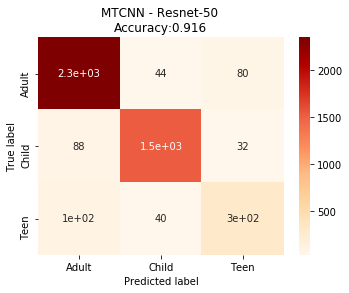

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = le.classes_, 
                     columns = le.classes_)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap="OrRd")
plt.title('MTCNN - Resnet-50 \nAccuracy:{0:.3f}'.format(accuracy_score(y_true_test, y_pred_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()